In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

# Условие

**В этом домашнем задании вы должны написать свою сплит систему для проведения A/B тестов**

В предоставленных данных есть 50000 юзеров, для каждого есть запись какой-то метрики за 2 года (730 дней).

Данные: https://disk.yandex.ru/d/2mH8fuKCKLeozg


### Ваша задача:

1) Написать алгоритм, которые разбивает данные на 3 группы размера около 5000, которые будут считаться "похожими".

- Для этого вам самостоятельно нужно решить, какие критерии схожести тут применимы и построить необходимые тесты для выбора этих групп.

- Данные 3 группы должны считаться похожими на основе ваших метрик.

- Разбиение затем будет протестировано на следующих 2х годах нами.

2) Визуализировать распределения выбранных вами метрик для найденных групп и сравнить с аналогичными разультатами для случайных групп

### Нужно реализовать следующие функции (вы можете добавлять какие-то побочные, если считаете нужным):

`generate_groups`  - функция, которая по данным и числу групп делает случайное разбиение данных на примерно одинаковые части по количеству групп

`conduct_test_on_pair` - функция проводит статистические тесты между двумя данными группами и возвращает нужные статистики и результаты

`conduct_tests` -- по списку групп и количеству необходимых похожих групп (зафиксировано в условии задачи как 3) перебирает возможные тройки групп пока не найдет похожие, критерий остановки за вами

`find_groups` -- берет данные и число групп, на которое вы их разбиваете и ищет 3 группы удовлетворяющие вашим критериям схожести.

Рекомендуем начинать с того, чтобы искать разбиение на 2 группы, а не 3, чтобы проверить, что сплит система работает адекватно. Задача с двумя группами зачастую сильно проще, чем с тремя.

Группы должны состоять из уникальных клиентов без дубликатов, один клиент может быть только в одной группе. То есть должны выбирать группы из датасета без повторений и у групп не должно быть пересечений.

 Про то, по каким параметрам оценивать группы: в этом задании вам требуется найти группы, в которых распределения **средних значений и дисперсии данной последовательности** по пользователям похожи. То есть вам нужно вычислить среднее значение и дисперсию данной последовательности для каждого пользователя, а затем проверить, что распределения результатов между группами схожи по вашим тестам.


**Замечание**: Для разбиения на группы и сравнения похожести можете брать любую метрику и считать любой критерии, но мы будем сравнивать именно метрику «среднее» и дисперсию на следующих по времени данных

#### Про систему оценивания: При оценивании мы будем проверять полученные вами группы как на этих данных, так и на следующих двух годах. При проверке будем учитывать и качество полученных групп при помощи метрик.

In [2]:
import pandas as pd
import numpy as np
import gdown
from scipy.stats import mannwhitneyu, ttest_ind, levene
from itertools import combinations
import matplotlib
import seaborn as sns

# Загрузим файл по ссылке с Google Диска
url = 'https://drive.google.com/uc?id=1qiDcTapez7wmLTuweRfX9O9Y4kRYEmfs'
data = 'train_data.csv'
gdown.download(url, data, quiet=False)

df = pd.read_csv(data, delimiter=',')

Downloading...
From (original): https://drive.google.com/uc?id=1qiDcTapez7wmLTuweRfX9O9Y4kRYEmfs
From (redirected): https://drive.google.com/uc?id=1qiDcTapez7wmLTuweRfX9O9Y4kRYEmfs&confirm=t&uuid=a6b2c09e-395e-4595-b21f-ff6ff1015626
To: /content/train_data.csv
100%|██████████| 692M/692M [00:06<00:00, 110MB/s]


In [3]:
df.head() # Посомтри, как выглядят наши данные

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30
0,-3.533155,-4.475755,-4.748074,-5.569953,-8.017896,-12.396771,-11.853961,-12.046498,-10.297042,-10.075553,...,-168.163849,-168.728405,-168.971555,-168.824042,-167.700081,-167.634364,-167.856116,-168.743465,-168.231590,-167.913551
1,-3.824475,-1.530769,0.038338,-1.475237,-1.602029,-0.992509,0.302906,1.789140,4.177589,9.273372,...,75.919063,72.909418,75.289867,77.770907,74.099941,72.411474,67.472791,67.084800,66.805609,72.078232
2,-1.616434,-4.658834,-6.746498,-9.979424,-11.683396,-9.507703,-7.614438,-9.735666,-10.754863,-11.058539,...,47.759469,46.596598,50.135737,48.424880,47.740658,46.676116,45.611939,43.331310,45.655325,39.770838
3,-0.157282,1.827617,-2.585284,-4.397189,0.113494,7.614615,5.456654,5.928451,6.953534,4.514409,...,318.364962,319.281629,322.614999,325.200268,324.745069,326.519830,326.467326,321.806523,321.286907,323.570847
4,2.056969,10.187929,8.559520,8.579555,9.464262,9.038088,10.875990,9.883777,8.026472,13.040411,...,-38.079584,-38.515039,-38.031876,-36.610698,-37.753387,-35.470938,-35.454435,-35.026979,-35.633306,-35.460477


## Напишите следующие функции

In [9]:
def generate_groups(df, group_num):
    """
    Splits users into group_num groups of similar size

    df : Dataframe with all user data
    group_num : number of groups to split into

    returns a list of dataframes of generated groups
    """
    # permutations обеспечит случайность выбора наших групп, поэтому основные описательные статистики между группами будут равны при большом числе наблюдений, и группы будут похожими
    n_users = len(df)
    indexes_to_choose = np.random.permutation(n_users) # Создадим последовательность перестановок длины n
    group_indexes = np.array_split(indexes_to_choose, group_num) # Поделим данные на равные группы, получим списки индексов для каждой группы (список списков)
    groups = []
    for indexes in group_indexes:
        group = df.iloc[indexes]
        groups.append(group)
    return groups

# def generate_groups(data, num_groups):
#     shuffled_data = data.sample(frac=1) # перемешаем пользователей
#     groups = [pd.DataFrame() for _ in range(num_groups)] # создаем num_groups df

#     while len(shuffled_data) > 0: # Пока пользователи не кончились
#         best_cost_reduction = 100000000000 # макс значение ставим, чтобы потом с ним сравнивать
#         best_group = None
#         best_candidate_idx = None

#         # Находим пару наблюдений, которая максимально уменьшает стоимость
#         for i, group in enumerate(groups):  # -> (0,0), (1,1), (2,2)
#             for j, candidate_idx in enumerate(shuffled_data.index):
#                 candidate = shuffled_data.loc[[candidate_idx]] # берем челика
#                 group_combined = pd.concat([group, candidate]) # добавляем в группу
#                 cost_reduction = calculate_cost_reduction(groups, group_combined) # считаем функцию потерь

#                 if cost_reduction < best_cost_reduction: # Обновляем настройки, если у новой группы функция потерь меньше, чем у прошлых
#                     best_cost_reduction = cost_reduction
#                     best_group = i
#                     best_candidate_idx = candidate_idx

#         # Как нашли два челика, раскидываем их по группам
#         groups[best_group] = pd.concat([groups[best_group], shuffled_data.loc[[best_candidate_idx]]]) # добавляем нового найденного челика в группу
#         shuffled_data = shuffled_data.drop(best_candidate_idx) # и удаляем распределенного в группы челика, повторяем, пока shuffled_data не станет пустым

#     return groups

# # Функция для вычисления изменения стоимости при добавлении наблюдения в группу
# def calculate_cost_reduction(groups, group_combined):
#     # Рассчитываем изменение стоимости как сумму различий между группами
#     cost_reduction = 0
#     for group in groups:
#         cost_reduction += abs(group_combined.mean(axis=1) - group.mean(axis=1)) + abs(group_combined.var(axis=1) - group.var(axis=1))
#     return cost_reduction



# # Генерируем 3 группы
# generated_groups = generate_groups(df, 10)

# np.random.seed(123)
def conduct_tests_on_pair(df_1, df_2):
    """
    Conducts statistical test or tests on two given groups to decide if they are similar

    df_i : Dataframe of users of a single group

    returns p-value or anything you need further
    """
    means_df_1 = df_1.mean(axis=1)  # Сначала посчитаем среднее значение по времени для каждого пользователя в каждой группе, потом сравним средние значения пользователей двух групп между собой на равенство мат ожидания двух групп
    means_df_2 = df_2.mean(axis=1)

    var_df_1 = df_1.var(axis=1) # То же самое с дисперсиями
    var_df_2 = df_2.var(axis=1)

    stat_tt, p_tt = stats.ttest_ind(means_df_1, means_df_2)
    stat_mw, p_mw = mannwhitneyu(means_df_1, means_df_2)
    stat_lev, p_lev = levene(var_df_1, var_df_2)

    # print(f'Двусторонний t-тест, тестовая статистика: {stat_tt}, p-value: {p_tt}')
    # print(f'Тест Mann-Witney, тестовая статистика: {stat_mw}, p-value: {p_mw}')
    # print(f'Тест Левене, тестовая статистика: {stat_lev}, p-value: {p_lev}')
    return stat_tt, p_tt, stat_mw, p_mw, stat_lev, p_lev


# print(conduct_tests_on_pair(generated_groups[0], generated_groups[1]))

def conduct_tests(dfs, group_num):
    """
    Goal is to find out if there is group_num groups in the dfs list which are similar enough according to your criterion.
    For every (or maybe not every) selection of group_num groups from the dfs list and conducts pairwise tests on selected subset using conduct_tests_on_pair.

    dfs : list of dataframes of groups

    returns list of selected groups or None if there are no similar groups
    """
    group_combinations = combinations(dfs, group_num) # комбинации групп для проверки
    for combination in group_combinations:
        # Стат тесты для проверки похожести: левене для проверки схожести дисперсий
        p_values_tt = []
        p_values_mw = []
        p_values_lev = []
        for df1, df2 in combinations(combination, 2):
            tt_stat, p_tt, mw_stat, p_mw, lev_stat, p_lev = conduct_tests_on_pair(df1, df2)
            p_values_tt.append(p_tt)
            p_values_mw.append(p_mw)
            p_values_lev.append(p_lev)

        # Будем требовать, чтобы все тесты не отвергались, уровень значимости возьмем побольше, чтобы группы были более похожими
        if all(p > 0.2 for p in p_values_tt) and all(p > 0.2 for p in p_values_mw) and all(p > 0.2 for p in p_values_lev):
            return list(combination)
    return None

def find_groups(df, group_num):
    """
    Splits df into groups and conducts tests on subsets of the groups until necessary groups are found
    """
    for i in range(100000):
        dfs = generate_groups(df, group_num)
        result = conduct_tests(dfs, 3)

        if result is not None:
            return result

In [ ]:
# df = pd.read_csv('train_data.csv')

In [10]:
group_num = 10

In [11]:
groups = find_groups(df, group_num)

In [ ]:
# for sample in groups:
#   print(sample)
#   print('-'*100 + '\n' + '-'*100)

# Visualize groups

Тут секция, где вам нужно визуализировать распределения выбранных вами метрик для найденных групп и сравнить с аналогичными разультатами для случайных групп

In [ ]:
groups_random = generate_groups(df, 10)

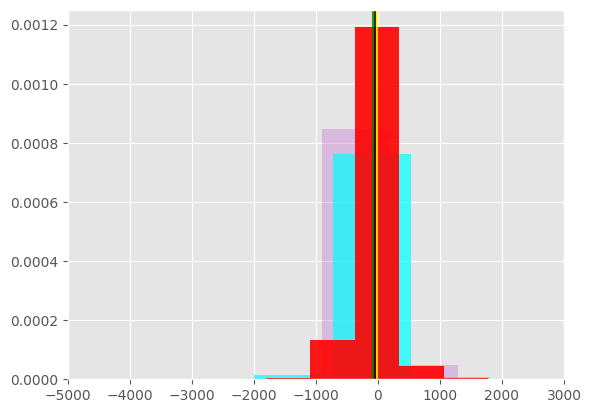

In [38]:
groups = find_groups(df, 10)
x1 = np.linspace(-1, 1, 100)
y1 = groups[0].mean(axis=1)
y2 = groups[1].mean(axis=1)
y3 = groups[2].mean(axis=1)
fig, ax = plt.subplots(1, 1)
ax.hist(y1, density=True, histtype='bar', bins=300, alpha=0.3, color='mediumorchid')
ax.hist(y2, density=True, histtype='bar', bins=300, alpha=0.7, color='cyan')
ax.hist(y3, density=True, histtype='bar', bins=300, alpha=0.9, color='red')
ax.axvline(np.mean(y1), ymax=1, color='black', alpha=0.8)
ax.axvline(np.mean(y2), ymax=1, color='green', alpha=0.8)
ax.axvline(np.mean(y3), ymax=1, color='yellow', alpha=0.8)
# rect = matplotlib.patches.Rectangle((np.mean(y1)-3*np.std(y1),0), 6*np.std(y1), 0.3, color='black', alpha=0.2)
# ax.add_patch(rect)
plt.xlim(-5000, 3000)
plt.show()

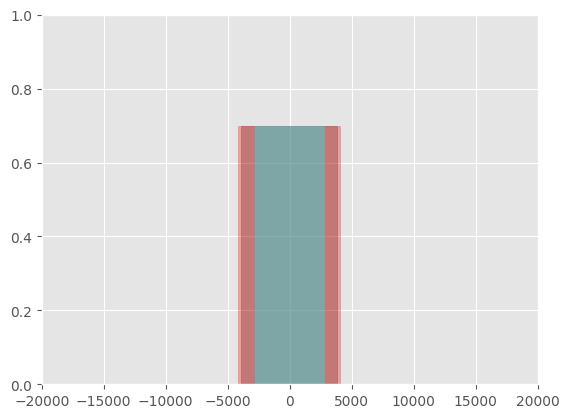

In [39]:
fig, ax = plt.subplots(1, 1)
rect1 = matplotlib.patches.Rectangle((np.mean(y1)-np.std(y1),0), 2*np.std(y1), 0.7, color='black', alpha=0.25)
rect2 = matplotlib.patches.Rectangle((np.mean(y2)-np.std(y2),0), 2*np.std(y2), 0.7, color='red', alpha=0.3)
rect3 = matplotlib.patches.Rectangle((np.mean(y3)-np.std(y3),0), 2*np.std(y3), 0.7, color='cyan', alpha=0.35)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
plt.xlim(-20000, 20000)
plt.show()

Видим, что средние и дисперсии примерно равны, потому что мы их так строили.

  0%|          | 0/10000 [00:00<?, ?it/s]

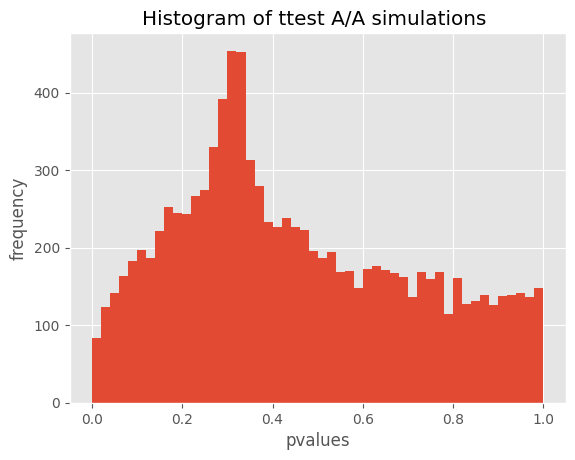

0.027

In [40]:
simulations = 10000
n_s = 50
res = []
from tqdm.auto import tqdm

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
  s1 = y1.sample(n_s, replace = False).values
  s2 = y3.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = True)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

При этом распределение p-value неравномерное. Это может быть связано с тем, что есть другие характеристики распределения данных, которые мы не учли в своем анализе. Проверим с помощью теста, чтобы убедиться:

In [41]:
from scipy.stats import kstest, uniform

def is_uniform(sample, significance_level):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value

significance_level = 0.05
# Example usage
p_value = is_uniform(res, significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Not Uniform


1.492651484311756e-116

Для y1, y2 и y2, y3 соотношение примерно такое же

  0%|          | 0/10000 [00:00<?, ?it/s]

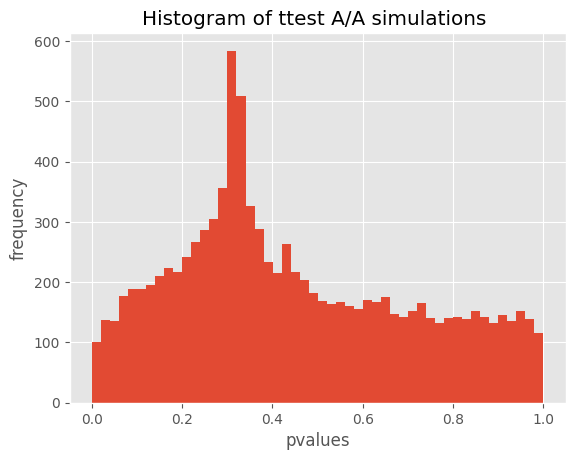

0.0295

In [42]:
simulations = 10000
n_s = 50
res = []
from tqdm.auto import tqdm

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
  s1 = y1.sample(n_s, replace = False).values
  s2 = y2.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = True)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

  0%|          | 0/10000 [00:00<?, ?it/s]

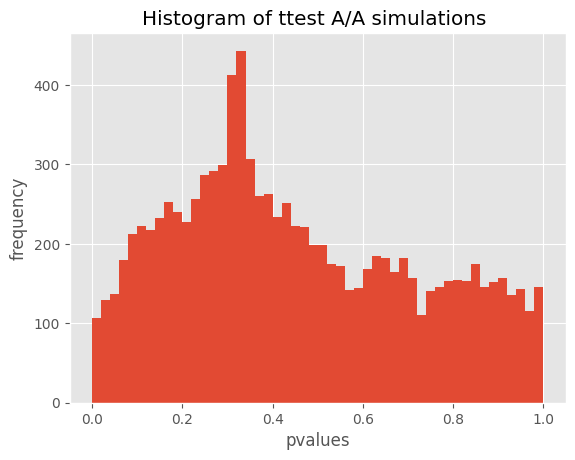

0.0306

In [43]:
simulations = 10000
n_s = 50
res = []
from tqdm.auto import tqdm

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
  s1 = y2.sample(n_s, replace = False).values
  s2 = y3.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = True)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Теперь сравним со случайной выборкой трех групп:

In [18]:
# df = pd.read_csv(data, delimiter=',')
y1 = df.iloc[:5000, :].mean(axis=1)
y2 = df.iloc[5000:10000, :].mean(axis=1)
y3 = df.iloc[10000:15000, :].mean(axis=1)

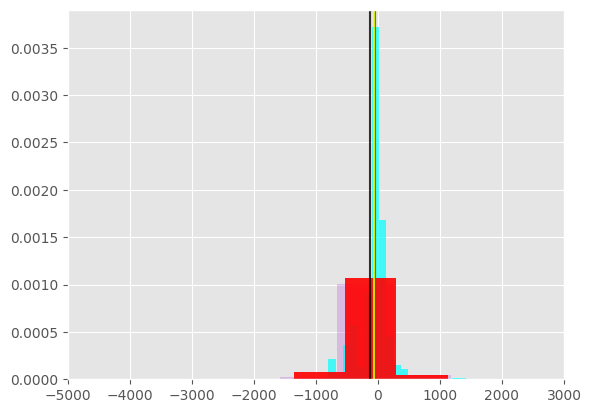

In [19]:
x1 = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(1, 1)
ax.hist(y1, density=True, histtype='bar', bins=300, alpha=0.3, color='mediumorchid')
ax.hist(y2, density=True, histtype='bar', bins=300, alpha=0.7, color='cyan')
ax.hist(y3, density=True, histtype='bar', bins=300, alpha=0.9, color='red')
ax.axvline(np.mean(y1), ymax=1, color='black', alpha=0.8)
ax.axvline(np.mean(y2), ymax=1, color='green', alpha=0.8)
ax.axvline(np.mean(y3), ymax=1, color='yellow', alpha=0.8)
# rect = matplotlib.patches.Rectangle((np.mean(y1)-3*np.std(y1),0), 6*np.std(y1), 0.3, color='black', alpha=0.2)
# ax.add_patch(rect)
plt.xlim(-5000, 3000)

plt.show()

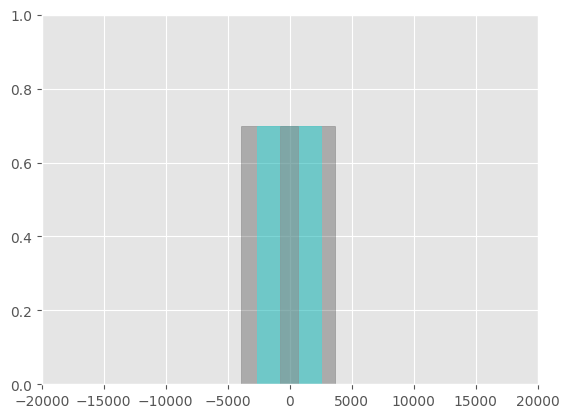

In [20]:
fig, ax = plt.subplots(1, 1)
rect1 = matplotlib.patches.Rectangle((np.mean(y1)-np.std(y1),0), 2*np.std(y1), 0.7, color='black', alpha=0.25)
rect2 = matplotlib.patches.Rectangle((np.mean(y2)-np.std(y2),0), 2*np.std(y2), 0.7, color='red', alpha=0.3)
rect3 = matplotlib.patches.Rectangle((np.mean(y3)-np.std(y3),0), 2*np.std(y3), 0.7, color='cyan', alpha=0.35)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
plt.xlim(-20000, 20000)
plt.show()

Матожидания тоже совпали, но дисперсии при этом немного отличаются

  0%|          | 0/10000 [00:00<?, ?it/s]

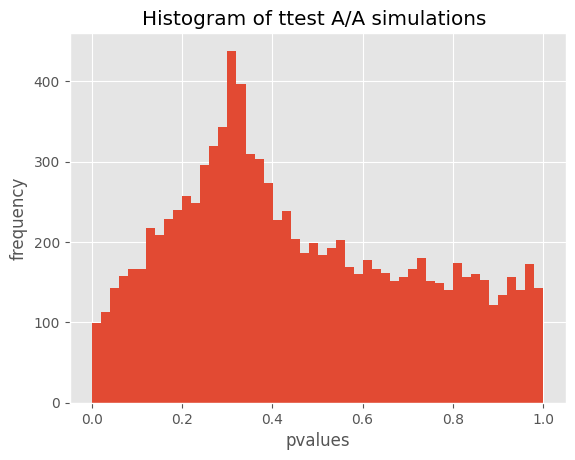

0.0278

In [21]:
# n = 100_000
simulations = 10000
n_s = 50
res = []
from tqdm.auto import tqdm

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
  s1 = y1.sample(n_s, replace = False).values
  s2 = y2.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Распределение p-value неравномерное, что подтверждается тестом:

In [22]:
from scipy.stats import kstest, uniform

def is_uniform(sample, significance_level):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value

significance_level = 0.05
# Example usage
p_value = is_uniform(res, significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Not Uniform


4.05287317324593e-88

Распределение неравномерное.

Результат говорит о том, что сплит-система отрабатывает не совсем корректно.
Я пытался построить жадный алгоритм отбора пользователей в группы, но, к сожалению, так и не смог реализовать полностью его. Жадный алгоритм дал бы более хорошие результаты, потому что сам метод основан на том, что мы отбираем пользователей, исходя из минимизации разности их метрик (матожидания и дисперсии) и получаем во всех группах пользователей с одинаковым распределением этих метрик.